In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# loading the embedding and the query information
misconception = np.load('misconception_embedding.npy')
print(f"Total number of misconceptions {misconception.shape}")
query = np.load('train_query_embedding.npy')
print(f"Total number of different queries {query.shape}")
query_df = pd.read_csv('train_query.csv')

# normalize the embeddings
misconception = misconception / np.linalg.norm(misconception, axis=1)[:, None]
query = query / np.linalg.norm(query, axis=1)[:, None]

# split the dataset 
def extract_id(x):
    return x.split("_")[0]
query_df["question_id"] = query_df["QuestionId_Answer"].apply(extract_id)
question_ids = query_df["question_id"].unique()
train_question, test_question = train_test_split(question_ids, test_size=0.1, random_state=42)
train_query_idx = query_df[query_df["question_id"].isin(train_question)].index
test_query_idx = query_df[query_df["question_id"].isin(test_question)].index

train_query = query[train_query_idx]
test_query = query[test_query_idx]

print(f"size of train dataset {train_query.shape}")
print(f"size of test dataset {test_query.shape}")

Total number of misconceptions (2587, 4096)
Total number of different queries (4370, 4096)
size of train dataset (3930, 4096)
size of test dataset (440, 4096)


In [2]:
# For each train query, find the top k similar misconceptions
k = 25
similarity = np.dot(train_query, misconception.T)
top_k_idx = np.argsort(similarity, axis=1)[:, -k:][:,::-1]
top_k_similarity = similarity[np.arange(similarity.shape[0])[:, None], top_k_idx]    # (N, k)

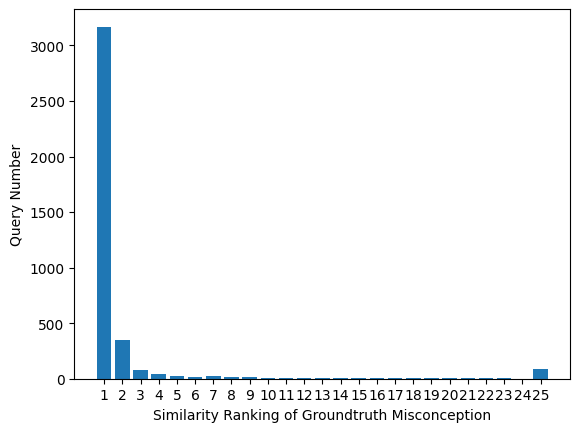

In [3]:
import matplotlib.pyplot as plt
# calculate and display the ranking of ground truth misconception
ground_truth_idx = query_df["MisconceptionID"].values[train_query_idx].astype(int)
stats = [0 for i in range(k)]
for gt_idx, s_ind in zip(ground_truth_idx, top_k_idx):
    # if ranking of train query is lower than k, we just set it as k
    if gt_idx in s_ind:
        eq_idx = np.argwhere(s_ind == gt_idx)[0][0]
        #eq_idx = k-1 if len(eq_idx) == 0 else eq_idx[0]
    else:
        eq_idx = k-1
    stats[eq_idx] += 1

x = [i+1 for i in range(k)]
plt.bar(x, stats)
plt.xticks(x)
plt.xlabel("Similarity Ranking of Groundtruth Misconception")
plt.ylabel("Query Number")
plt.show()
    

In [4]:
# Sample training dataset from train query:
# Negative Sample: Query , Top k similar misconception (Not Groundtruth)
# Positive Sample: Query , Groundtruth misconception
# Idea: 
# For queries where groundtruth misconception rank top 1 -> simple training sample
# sample 1 positive | 1 negative
# For other queries groundtruth misconception rank lower -> hard training sample
# sample 1 positive | 3 negative
import random 
import torch
# fix the seed for random sampling
np.random.seed(0)
random.seed(0)

simple_neg_sample_num = 5
hard_neg_sample_num = 10
positive_oversample = 10
train_pairs = []
y = []
for i in range(len(train_query)):
    gt_idx = ground_truth_idx[i]
    top_k_ind = top_k_idx[i]
    # positive 
    train_pairs += [(i,gt_idx) for _ in range(positive_oversample)]
    y += [1 for _ in range(positive_oversample)]
    # negative
    if gt_idx == top_k_ind[0]: # simple example
        top_k_ind_r_gt = list(set(top_k_ind) - set([gt_idx]))
        neg_mises = np.random.choice(top_k_ind_r_gt,simple_neg_sample_num)
        train_pairs += [(i,neg_mis) for neg_mis in neg_mises]
        y += [0 for i in range(simple_neg_sample_num)]
    else:
        top_k_ind_r_gt = list(set(top_k_ind) - set([gt_idx]))
        neg_mises = np.random.choice(top_k_ind_r_gt,hard_neg_sample_num)
        train_pairs += [(i,neg_mis) for neg_mis in neg_mises]
        y += [0 for i in range(hard_neg_sample_num)]

# transfer data to tensor
train_pair_q, train_pair_m = zip(*train_pairs)
misconception = torch.tensor(misconception).to(torch.float32)
train_query = torch.tensor(train_query).to(torch.float32)
train_pair_q = train_query[torch.tensor(train_pair_q)].to(torch.float32)
train_pair_m = misconception[torch.tensor(train_pair_m)].to(torch.float32)
test_query = torch.tensor(test_query).to(torch.float32)
y = torch.tensor(y).to(torch.float32)


In [5]:
def apk(actual, predicted, k=25):
    """
    Computes the average precision at k.
    
    This function computes the average prescision at k between two lists of
    items.
    
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
        
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=25):
    """
    Computes the mean average precision at k.
    
    This function computes the mean average prescision at k between two lists
    of lists of items.
    
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
        
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def count_score(top_k_idx, ground_truth_idx):
    cnt = 0
    for gt_idx, k_ind in zip(ground_truth_idx, top_k_idx):
        if gt_idx in k_ind:
            cnt += 1
    return cnt/len(ground_truth_idx)
            

def evaluation(model, test_query, misconception, test_query_idx, k = 25, split = "train"):
    gt_misconception = query_df["MisconceptionID"].values[test_query_idx].astype(int)
    gt_misconception = [np.array([i]) for i in gt_misconception]
    similarity = model(test_query, misconception)
    top_k_idx = torch.argsort(similarity, dim=1, descending=True)[:, :k]
    model_apk = mapk(gt_misconception, top_k_idx.cpu().numpy(), k)
    #print(count_score(top_k_idx.cpu().numpy(), gt_misconception))
    
    similarity = torch.matmul(test_query, misconception.T)
    top_k_idx = torch.argsort(similarity, dim=1, descending=True)[:, :k]
    baseline_apk = mapk(gt_misconception, top_k_idx.cpu().numpy(), k)
    print(f"Model {split} MAP@{k}: {model_apk}, Baseline MAP@{k}: {baseline_apk}")
    

In [6]:
# train model
# define a simple scoring Neural Network for training
# maybe concatenation? (Q:M) -> score or (Q+M) -> score
# or Q@W1@W2^T@M^T -> score
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm import tqdm

class ScoringNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ScoringNN, self).__init__()
        self.query_input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.ReLU(),
            # nn.Linear(hidden_dim, hidden_dim//2),
        )
        self.mis_input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.ReLU(),
            # nn.Linear(hidden_dim, hidden_dim//2),
        )
        self.criterion = torch.nn.BCELoss()

    def forward(self, Q, M):
        
        res_Q = self.query_input(Q)
        res_M = self.mis_input(M)
        return torch.matmul(Q,M.T)*0.9 + torch.matmul(res_Q,res_M.T)*0.1

    def loss(self, score, y):
        # capture the diagonal elements
        match_score = torch.diagonal(score)
        match_score = torch.sigmoid(match_score)
        loss = self.criterion(match_score, y)
        return loss 
    

train_dataset = torch.utils.data.TensorDataset(train_pair_q, train_pair_m, y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
scoring_model = ScoringNN(4096,1024)
optimizer = Adam(scoring_model.parameters(), lr=1e-3, weight_decay=1e-5)
for epoch in range(5):
    avg_loss, batch_num = 0,0
    for batch_q, batch_m, batch_y in train_loader:
        score = scoring_model.forward(batch_q,batch_m)
        loss = scoring_model.loss(score, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        avg_loss += loss.item()
        batch_num += 1
    print(f"Epoch {epoch}: Loss {avg_loss/batch_num}")
    evaluation(scoring_model, train_query, misconception, train_query_idx)
    evaluation(scoring_model, test_query, misconception, test_query_idx, split = "test")


Epoch 0: Loss 0.4823894996678307
Model train MAP@25: 0.5374167040212876, Baseline MAP@25: 0.8657686832517338
Model test MAP@25: 0.3439274822668939, Baseline MAP@25: 0.8416858822297353
Epoch 1: Loss 0.2975545241502204
Model train MAP@25: 0.699283024766999, Baseline MAP@25: 0.8657686832517338
Model test MAP@25: 0.4628031474079165, Baseline MAP@25: 0.8416858822297353
Epoch 2: Loss 0.23458080999287384
Model train MAP@25: 0.7716468276106329, Baseline MAP@25: 0.8657686832517338
Model test MAP@25: 0.5177823047441503, Baseline MAP@25: 0.8416858822297353
Epoch 3: Loss 0.21117165966470186
Model train MAP@25: 0.8022698897783483, Baseline MAP@25: 0.8657686832517338
Model test MAP@25: 0.5632894221303136, Baseline MAP@25: 0.8416858822297353
Epoch 4: Loss 0.20150888588176954
Model train MAP@25: 0.8186354094944578, Baseline MAP@25: 0.8657686832517338
Model test MAP@25: 0.5698353608378396, Baseline MAP@25: 0.8416858822297353


In [7]:
# test model
# reranking the misconception for test queries and use recall@25 to test the model
torch.save(scoring_model.state_dict(), "scoring_model.pth")